# TimeGAN para Generación de Datos Sintéticos

## Implementación de Fase 3 para Tesis de Grado en Ingeniería en Ciencias de la Computación
______________________________________
- Escuela Politécnica Nacional

- Jeimmy Eche

_________________________
Este notebook implementa la **tercera fase** del proyecto, centrada en evaluar la utilidad de los datos generados sintéticamente mediante el modelo TimeGAN.

El objetivo de esta etapa es:

- Utilizar el mejor modelo de regresión evaluado en la Fase 2 (Gradient Boosting)
- **Predecir la Hamiltoniana (H)**, una magnitud física que representa la energía total (cinética + potencial) del sistema
- Aplicar el modelo predictor de H sobre:
  - 🧠 **Datos reales activos**
  - 🧠 **Datos sintéticos generados**
- Comparar las distribuciones, errores y correlaciones de la predicción de H entre ambos conjuntos de datos

Esto permite validar si los datos sintéticos **conservan propiedades físicas relevantes**, y si pueden ser utilizados con fines de simulación, diagnóstico o entrenamiento de modelos biomecánicos.

_________

## 1. Importación de librerías

In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import os


## 2. Cargar modelos y scaler (Gradient Boosting)

In [3]:
# Cargar modelos de regresión
model_der = joblib.load("C:/TIC_JE/Pasivos/modelos/derechaP/gbr_model_der.pkl")
model_izq = joblib.load("C:/TIC_JE/Pasivos/modelos/izquierdaP/gbr_model_izq.pkl")

# Cargar escaladores
scaler_der = joblib.load("C:/TIC_JE/Pasivos/modelos/derechaP/scaler_der.pkl")
scaler_izq = joblib.load("C:/TIC_JE/Pasivos/modelos/izquierdaP/scaler_izq.pkl")

print("✅ Modelos y scalers cargados correctamente")


✅ Modelos y scalers cargados correctamente


c:\TIC_JE\envi\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 3. Llamar a los datos de activos reales con sus respectivas predicciones

In [4]:
# Ruta donde están los CSV reales predichos
path_reales = "C:/TIC_JE/Pasivos/datosPredDer/unificados"

# Cargar archivos correspondientes a Gradient Boosting (terminan en 'GB')
files_real_pred = [f for f in os.listdir(path_reales) if f.endswith("GB.csv")]

# Cargar DataFrames
real_data = {file.replace(".csv", ""): pd.read_csv(os.path.join(path_reales, file)) for file in files_real_pred}

# Verificar carga
for name, df in real_data.items():
    print(f"{name}: {df.shape}")


Activo1_der_UnificadoGB: (5638, 19)
Activo1_izq_UnificadoGB: (6664, 19)
Activo2_der_UnificadoGB: (6819, 19)
Activo2_izq_UnificadoGB: (5603, 19)


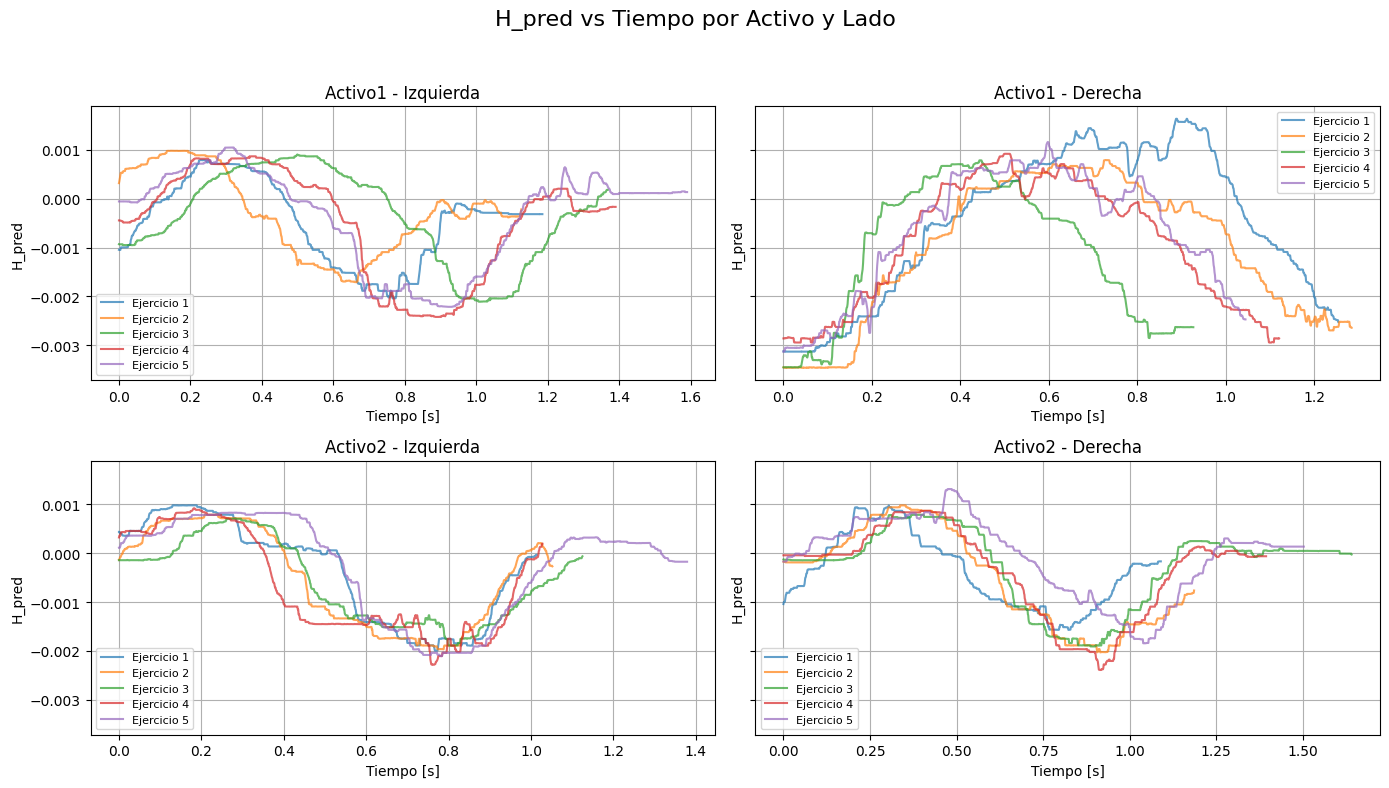

In [12]:
import matplotlib.pyplot as plt

exercise_labels = ['Ejercicio 1', 'Ejercicio 2', 'Ejercicio 3', 'Ejercicio 4', 'Ejercicio 5']

def graficar_HvsT(real_data):
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
    fig.suptitle("H_pred vs Tiempo por Activo y Lado", fontsize=16)

    # Mapeo para acceder al subplot correspondiente
    position_map = {
        ('activo1', 'izq'): axes[0, 0],
        ('activo1', 'der'): axes[0, 1],
        ('activo2', 'izq'): axes[1, 0],
        ('activo2', 'der'): axes[1, 1],
    }

    for name, df in real_data.items():
        lado = "izq" if "izquierda" in name.lower() or "izq" in name.lower() else "der"
        activo = "activo1" if "activo1" in name.lower() else "activo2"
        ax = position_map[(activo, lado)]

        for label in exercise_labels:
            exercise_dfD = df[df['Etiqueta'] == label]
            if not exercise_dfD.empty:
                ax.plot(exercise_dfD["tr_01"], exercise_dfD["Hpred0"], label=label, alpha=0.7)

        ax.set_title(f"{activo.capitalize()} - {'Izquierda' if lado == 'izq' else 'Derecha'}")
        ax.set_xlabel("Tiempo [s]")
        ax.set_ylabel("H_pred")
        ax.legend(fontsize=8)
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

graficar_HvsT(real_data)

## 4. Predecir H en datos sintéticos

In [32]:
import os
import pandas as pd
import numpy as np
from glob import glob

def predecir_H_sinteticos(path_root_synth, path_output, model_der, model_izq, scaler_der, scaler_izq):
    columnas = ['pxr_01','pyr_01','pzr_01','vel1_01','vel2_01','vel3_01']

    for activo in ["activos1", "activos2"]:
        for lado in ["derecha", "izquierda"]:
            path = os.path.join(path_root_synth, activo, lado)
            if not os.path.exists(path):
                continue

            ejercicios = os.listdir(path)
            for ejercicio in ejercicios:
                ejercicio_path = os.path.join(path, ejercicio)
                if not os.path.isdir(ejercicio_path):
                    continue

                archivos = glob(os.path.join(ejercicio_path, "*.csv"))
                for file_path in archivos:
                    df = pd.read_csv(file_path)

                    # Verifica columnas necesarias
                    if not all(col in df.columns for col in columnas):
                        print(f"⚠️ Saltando archivo sin columnas necesarias: {file_path}")
                        continue

                    # Conversión mm → m
                    df[columnas] = df[columnas] * 0.001

                    # Escalar y predecir
                    X = df[columnas].values
                    scaler = scaler_der if lado == "derecha" else scaler_izq
                    model  = model_der if lado == "derecha" else model_izq
                    X_scaled = scaler.transform(X)
                    df["Hpred0"] = model.predict(X_scaled)

                    # Crear ruta de salida por paciente
                    filename = os.path.basename(file_path)
                    paciente = filename.split("_")[0]  # paciente1
                    out_folder = os.path.join(path_output, paciente)
                    os.makedirs(out_folder, exist_ok=True)
                    out_path = os.path.join(out_folder, filename)
                    df.to_csv(out_path, index=False)

    print("✅ Predicciones con H_pred correctamente guardadas en pPredict/")


In [33]:
predecir_H_sinteticos(
    path_root_synth="C:/TIC_JE/Activos/syntheticData/pExercise",
    path_output="C:/TIC_JE/Activos/syntheticData/pPredict",
    model_der=model_der,
    model_izq=model_izq,
    scaler_der=scaler_der,
    scaler_izq=scaler_izq
)

c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X doe

✅ Predicciones con H_pred correctamente guardadas en pPredict/


c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\TIC_JE\envi\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X doe

In [36]:
def unificar_por_paciente_lado(input_base, output_base):
    """
    Une los CSV de predicción por paciente y lado en un único archivo con etiqueta por ejercicio.
    Guarda 4 archivos por paciente: Activo1_der, Activo1_izq, Activo2_der, Activo2_izq
    """
    for paciente_folder in os.listdir(input_base):
        paciente_path = os.path.join(input_base, paciente_folder)
        if not os.path.isdir(paciente_path):
            continue

        # Inicializar estructura: {(activo, lado): [DataFrames]}
        unificados = {("activos1", "derecha"): [],
                      ("activos1", "izquierda"): [],
                      ("activos2", "derecha"): [],
                      ("activos2", "izquierda"): []}

        for file in os.listdir(paciente_path):
            if not file.endswith(".csv"):
                continue

            df = pd.read_csv(os.path.join(paciente_path, file))

            # Extraer info de nombre de archivo
            parts = file.split("_")
            paciente = parts[0]                 # paciente1
            activo = parts[1]                   # activos1
            lado = parts[2]                     # derecha o izquierda
            ejercicio = parts[3].replace(".csv", "")  # EjercicioX

            df["Etiqueta"] = ejercicio
            df["time"] = df.index  # para asegurar consistencia en eje x si no hay columna de tiempo

            key = (activo, lado)
            unificados[key].append(df)

        # Guardar por cada combinación (activo, lado)
        for (activo, lado), lista_df in unificados.items():
            if lista_df:
                df_concat = pd.concat(lista_df, ignore_index=True)
                out_folder = os.path.join(output_base, paciente)
                os.makedirs(out_folder, exist_ok=True)
                out_name = f"{activo.capitalize()}_{lado}_H_{paciente.capitalize()}.csv"
                df_concat.to_csv(os.path.join(out_folder, out_name), index=False)

    print("✅ Unificación por paciente y lado completada y guardada en pPatient/")


In [37]:
unificar_por_paciente_lado(
    input_base="C:/TIC_JE/Activos/syntheticData/pPredict",
    output_base="C:/TIC_JE/Activos/syntheticData/pPatient"
)

✅ Unificación por paciente y lado completada y guardada en pPatient/


## 5. Visualización de resultados

In [40]:
def graficar_comparacion_real_vs_sintetico(real_data, synth_data):
    exercise_labels = ['Ejercicio1', 'Ejercicio2', 'Ejercicio3', 'Ejercicio4', 'Ejercicio5']
    colores = ['blue', 'green', 'orange', 'red', 'purple']

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
    fig.suptitle("Comparación H_pred: Real vs Sintético por Activo y Lado", fontsize=16)

    position_map = {
        ('activo1', 'izq'): axes[0, 0],
        ('activo1', 'der'): axes[0, 1],
        ('activo2', 'izq'): axes[1, 0],
        ('activo2', 'der'): axes[1, 1],
    }

    for name, df_real in real_data.items():
        lado = "izq" if "izquierda" in name.lower() or "izq" in name.lower() else "der"
        activo = "activo1" if "activo1" in name.lower() else "activo2"
        key = (activo, lado)
        ax = position_map[key]

        # Buscar archivo sintético correspondiente
        synth_key = [k for k in synth_data if activo in k.lower() and lado in k.lower()]
        if not synth_key:
            continue
        df_synth = synth_data[synth_key[0]]

        # Normalizar etiquetas
        df_real["Etiqueta"] = df_real["Etiqueta"].astype(str).str.replace(" ", "").str.lower()
        df_synth["Etiqueta"] = df_synth["Etiqueta"].astype(str).str.lower()

        for i, label in enumerate(exercise_labels):
            key_label = label.lower()

            # Reales
            real_ej = df_real[df_real["Etiqueta"] == key_label]
            if not real_ej.empty:
                tiempo_real_max = real_ej["tr_01"].max()
                ax.plot(real_ej["tr_01"], real_ej["Hpred0"], label=f"Real {label}",
                        color=colores[i], linewidth=2)

                # Sintéticos
                synth_ej = df_synth[df_synth["Etiqueta"] == key_label].copy()
                if not synth_ej.empty:
                    # Normalizar tiempo sintético para que coincida con tiempo real
                    synth_ej["time_norm"] = np.linspace(0, tiempo_real_max, len(synth_ej))
                    ax.plot(synth_ej["time_norm"], synth_ej["Hpred0"], linestyle='dotted',
                            color=colores[i], linewidth=2, label=f"Synth {label}")

        ax.set_title(f"{activo.capitalize()} - {'Izquierda' if lado == 'izq' else 'Derecha'}")
        ax.set_xlabel("Tiempo [s]")
        ax.set_ylabel("H_pred")
        ax.grid(True)
        ax.legend(fontsize=7)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


📈 Mostrando comparación H_pred para PACIENTE1


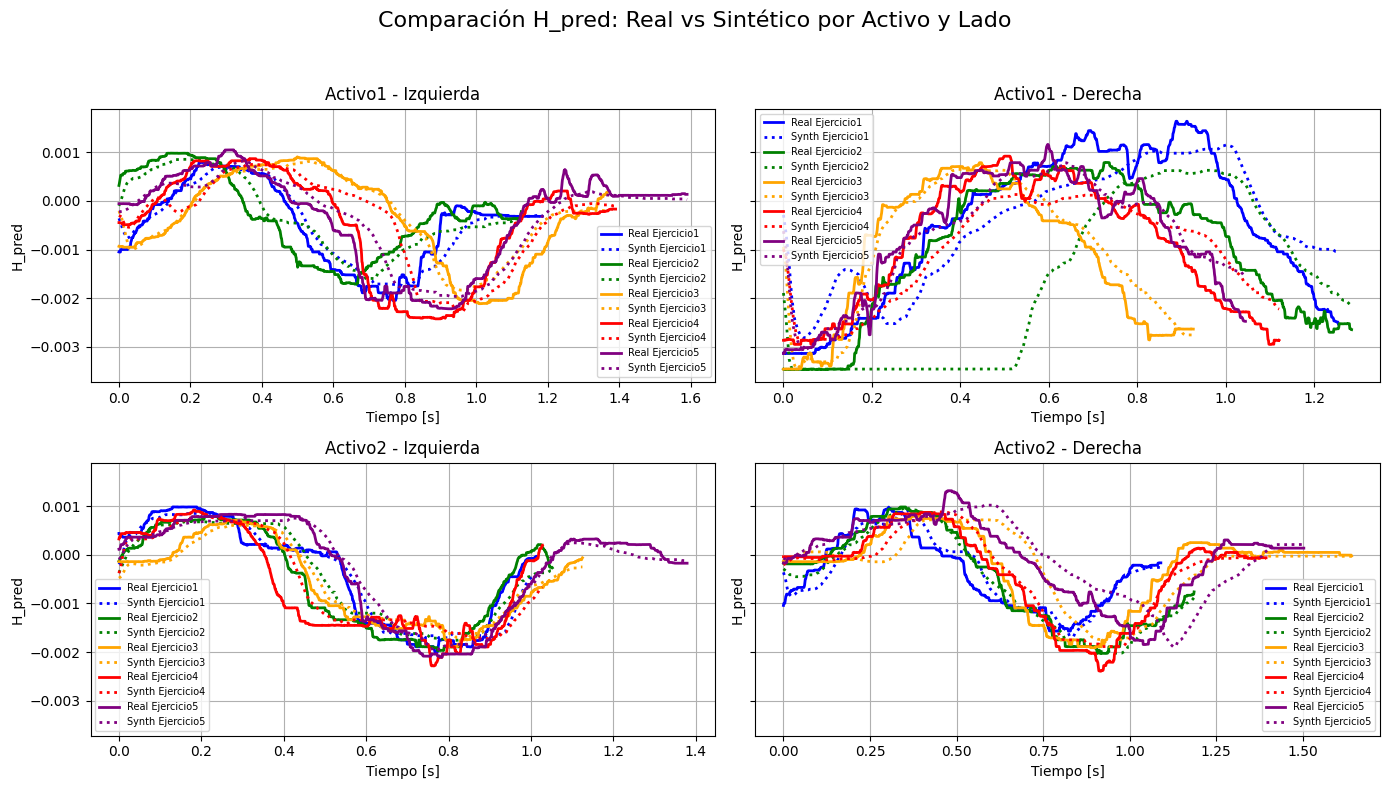

📈 Mostrando comparación H_pred para PACIENTE2


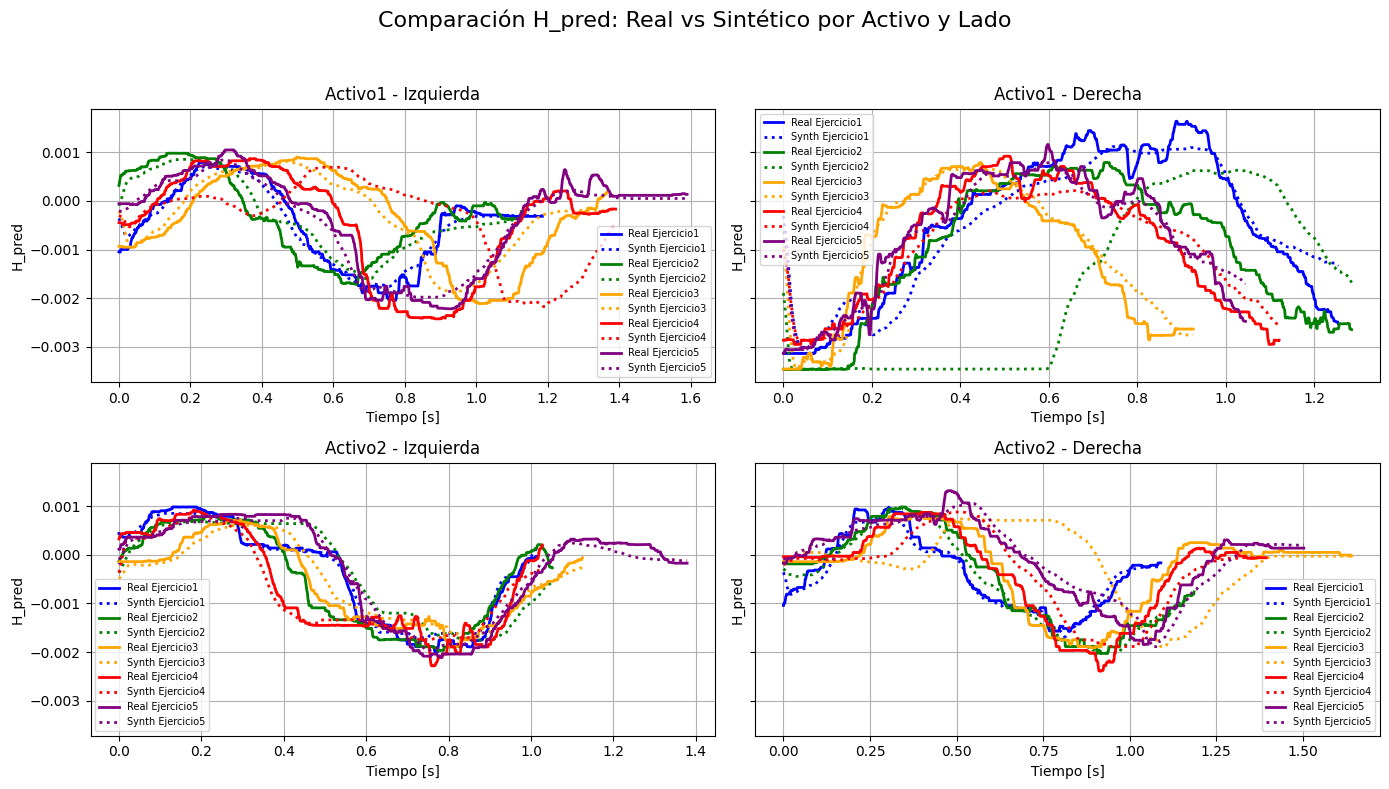

📈 Mostrando comparación H_pred para PACIENTE3


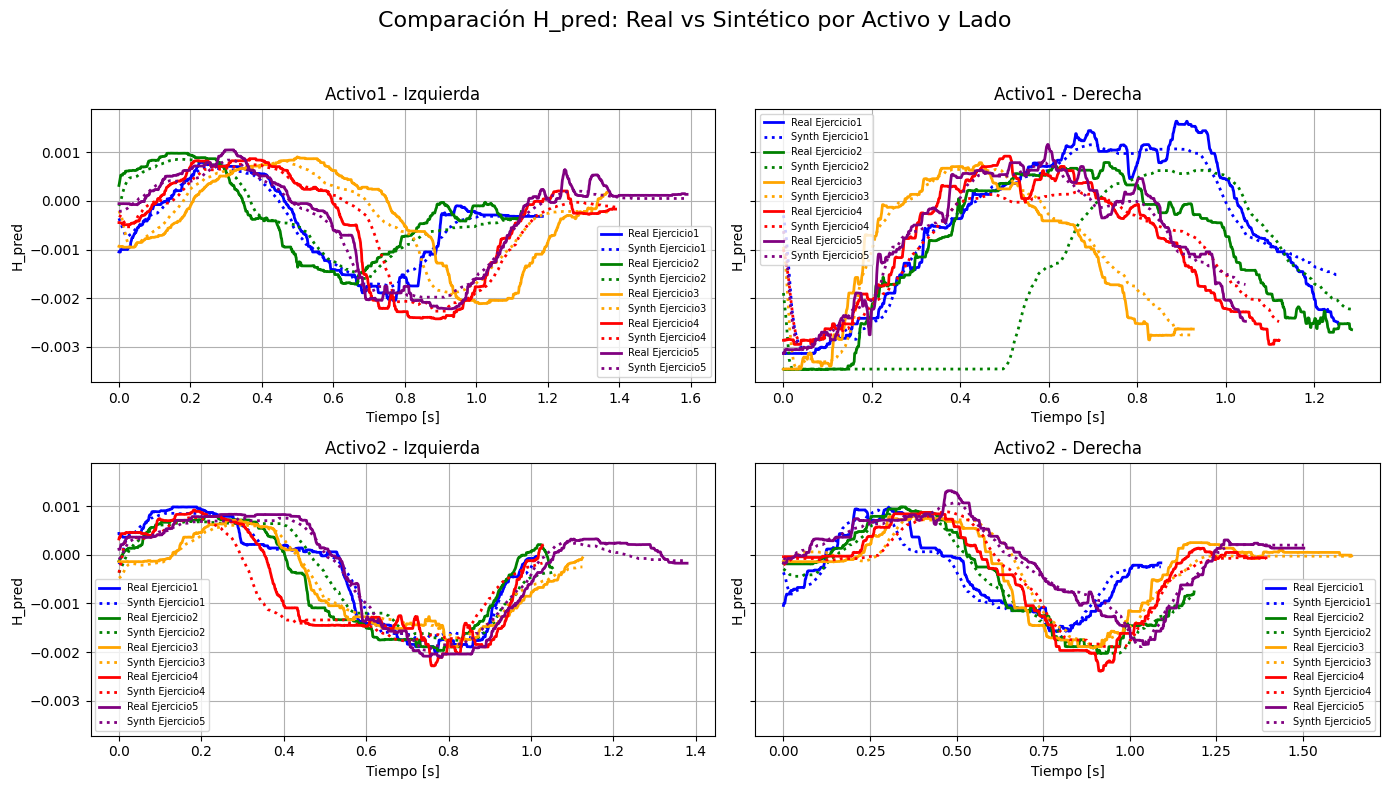

📈 Mostrando comparación H_pred para PACIENTE4


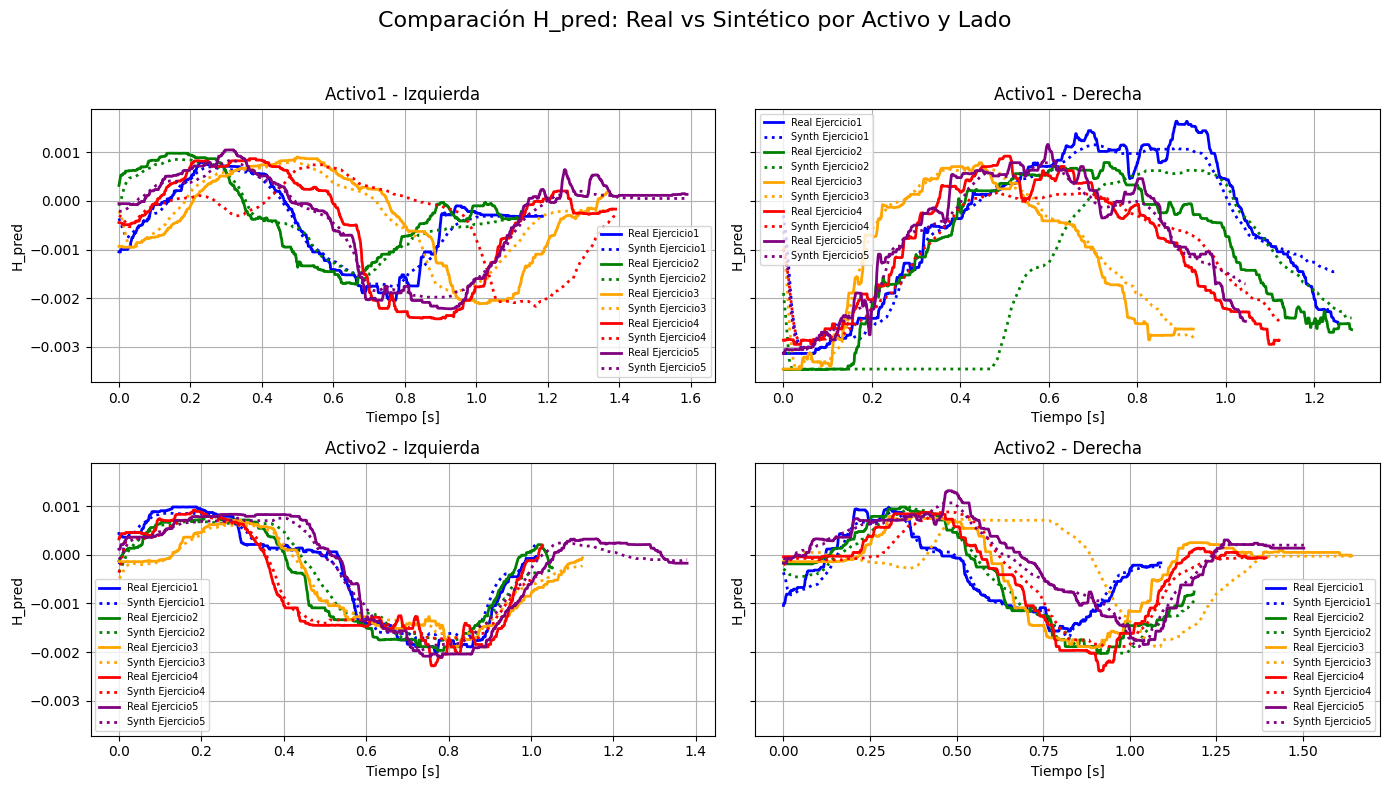

📈 Mostrando comparación H_pred para PACIENTE5


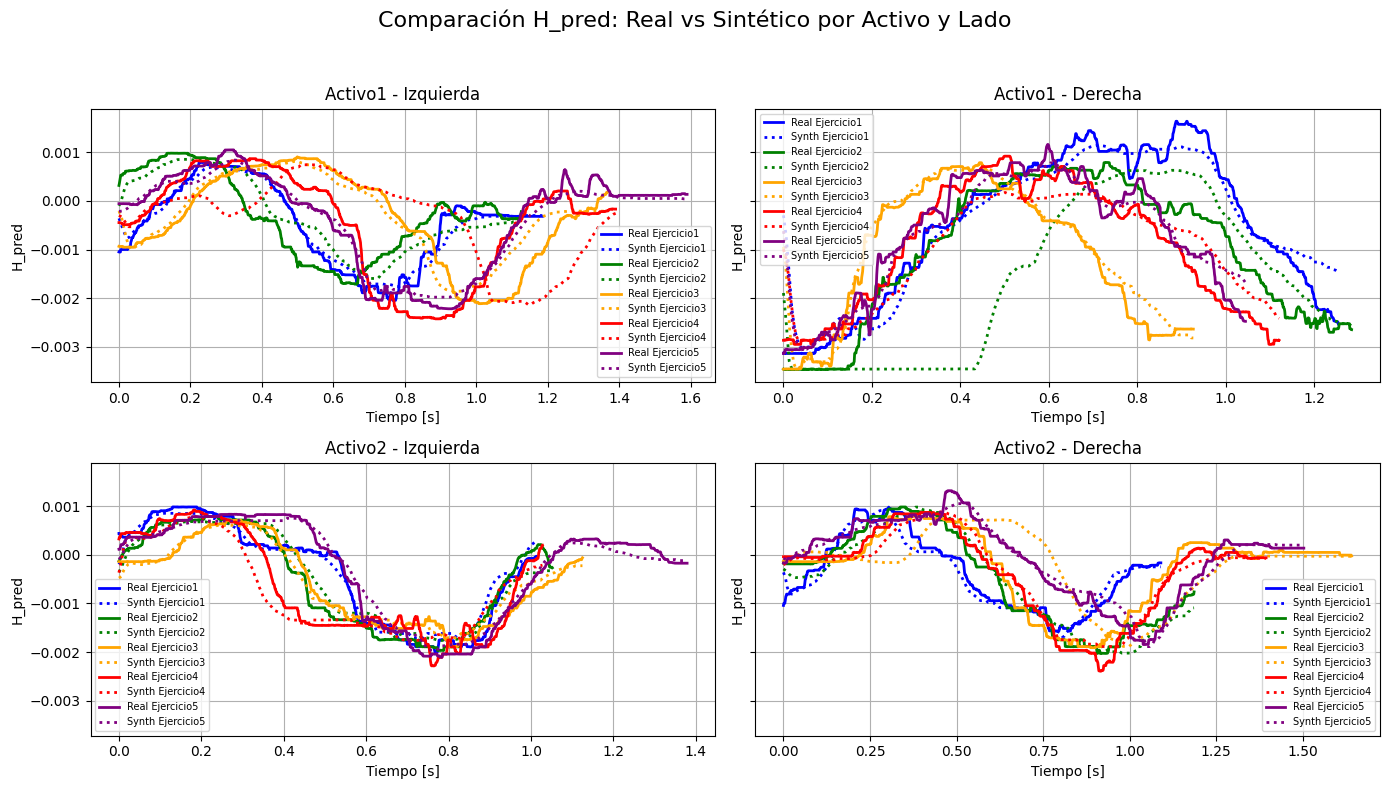

📈 Mostrando comparación H_pred para PACIENTE6


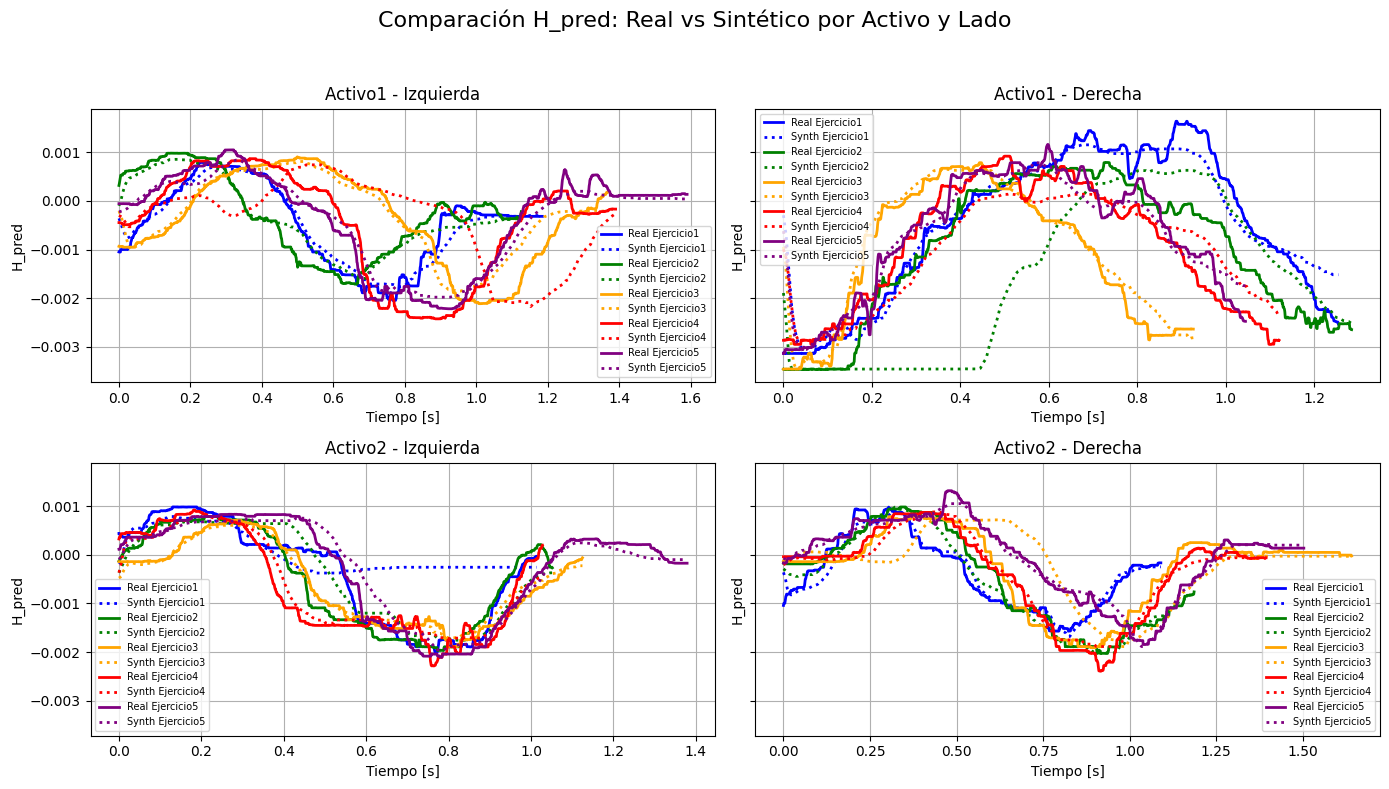

📈 Mostrando comparación H_pred para PACIENTE7


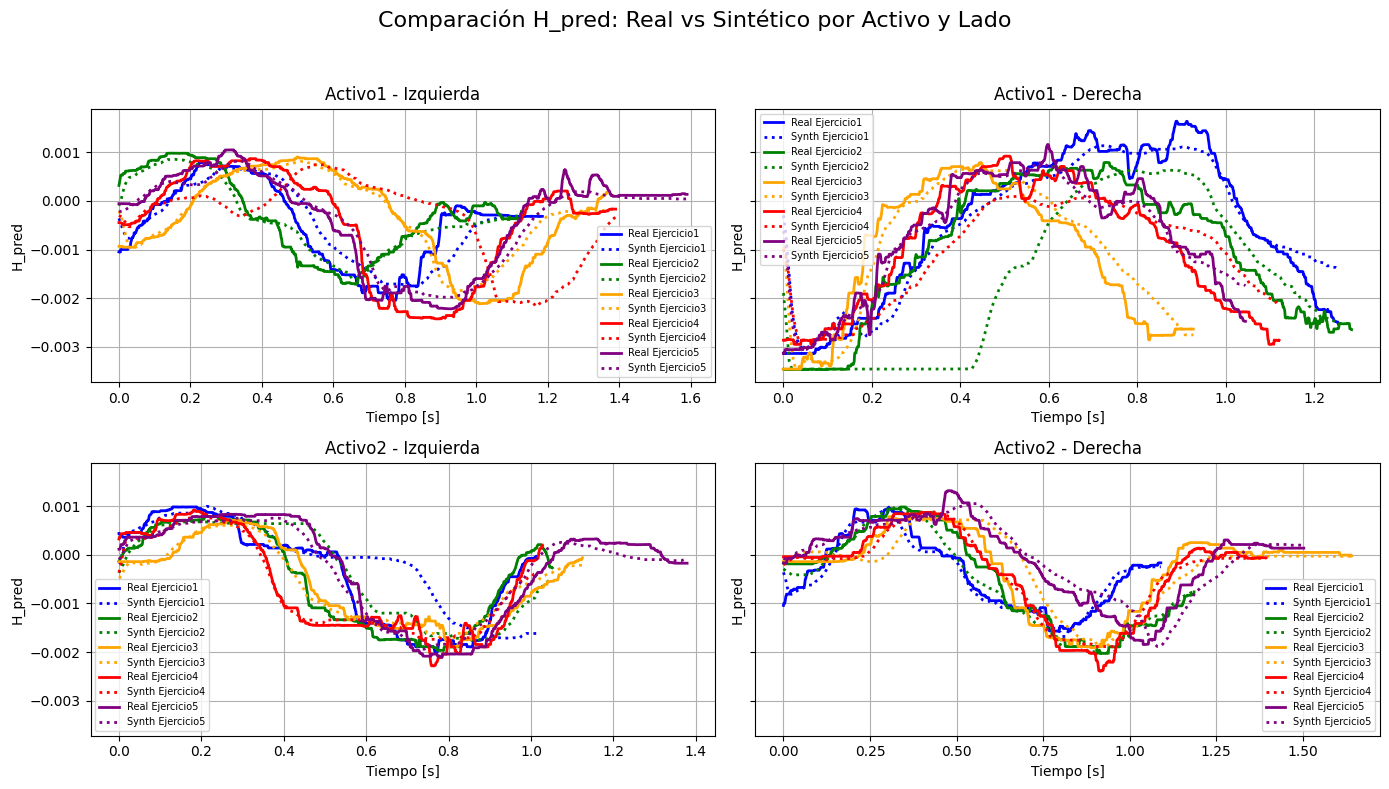

📈 Mostrando comparación H_pred para PACIENTE8


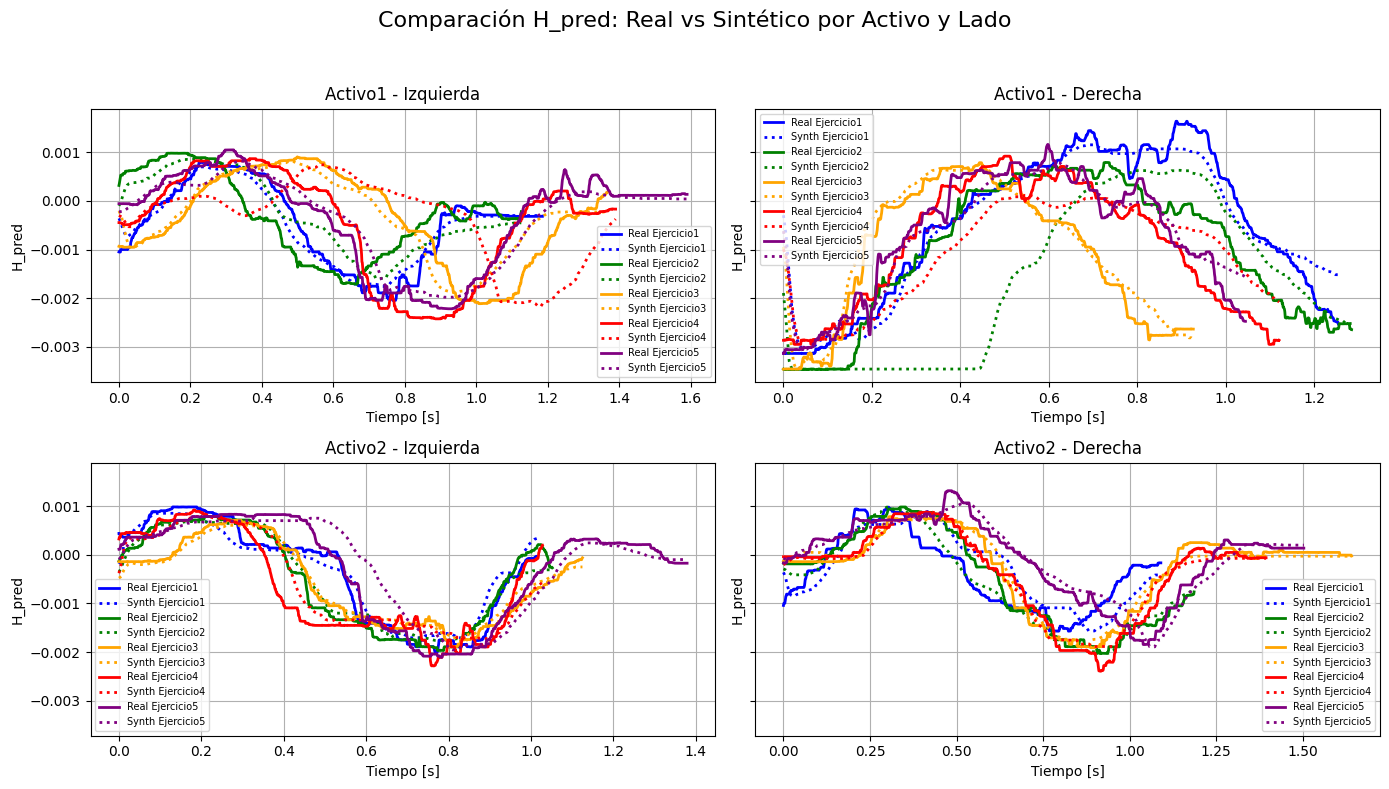

📈 Mostrando comparación H_pred para PACIENTE9


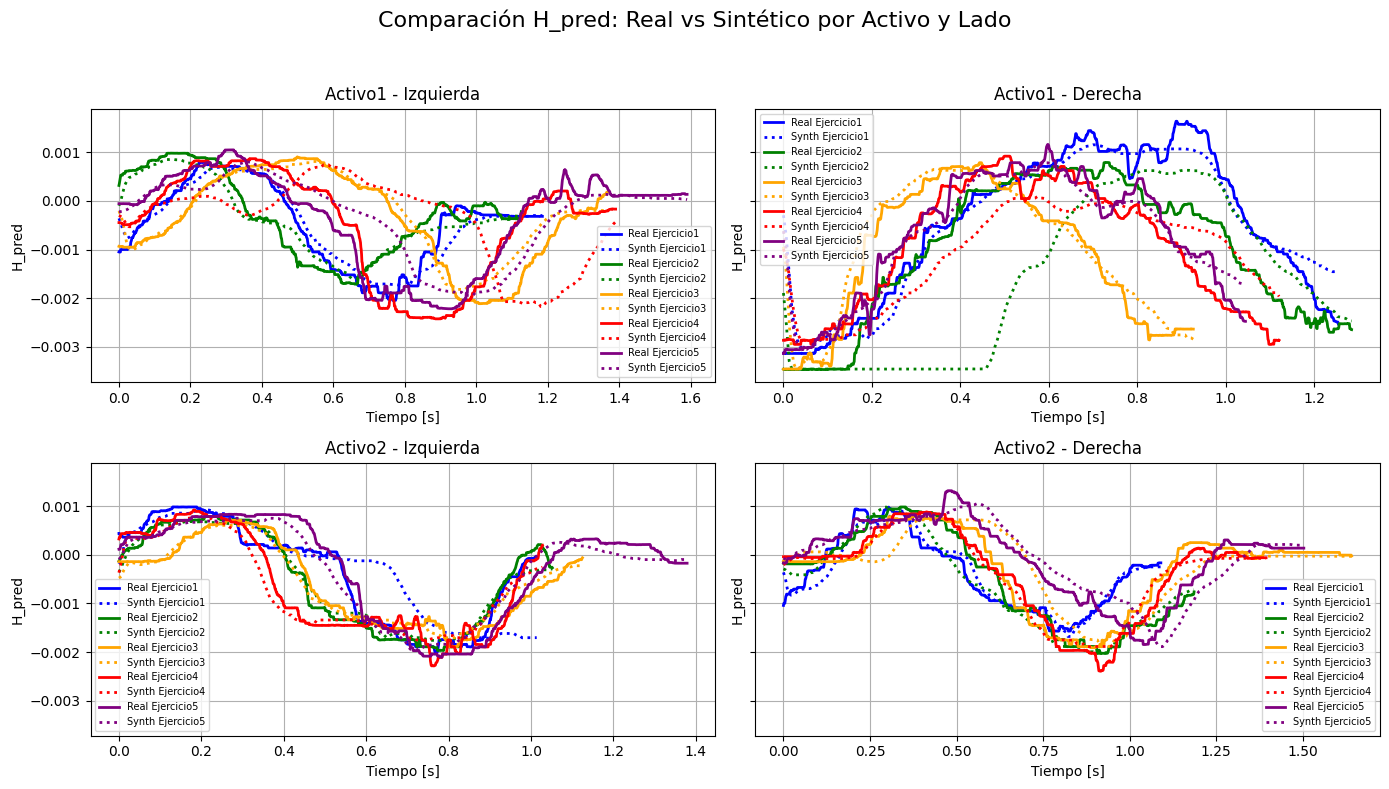

In [45]:
for i in range(1, 10):  # pacientes 1 al 9
    paciente = f"paciente{i}"
    pt = f"Paciente{i}"
    # Cargar datos sintéticos del paciente i
    synth_data = {
        "activo1_izquierda": pd.read_csv(f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/Activos1_izquierda_H_{pt.capitalize()}.csv"),
        "activo1_derecha": pd.read_csv(f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/Activos1_derecha_H_{pt.capitalize()}.csv"),
        "activo2_izquierda": pd.read_csv(f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/Activos2_izquierda_H_{pt.capitalize()}.csv"),
        "activo2_derecha": pd.read_csv(f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/Activos2_derecha_H_{pt.capitalize()}.csv"),
    }

    # Cargar datos reales (son los mismos para todos los pacientes)
    real_data = {
        "activo1_izquierda": pd.read_csv("C:/TIC_JE/Pasivos/datosPredDer/unificados/Activo1_izq_UnificadoGB.csv"),
        "activo1_derecha": pd.read_csv("C:/TIC_JE/Pasivos/datosPredDer/unificados/Activo1_der_UnificadoGB.csv"),
        "activo2_izquierda": pd.read_csv("C:/TIC_JE/Pasivos/datosPredDer/unificados/Activo2_izq_UnificadoGB.csv"),
        "activo2_derecha": pd.read_csv("C:/TIC_JE/Pasivos/datosPredDer/unificados/Activo2_der_UnificadoGB.csv"),
    }

    print(f"📈 Mostrando comparación H_pred para {paciente.upper()}")
    graficar_comparacion_real_vs_sintetico(real_data, synth_data)
    plt.savefig(rf"C:\TIC_JE\Pasivos\predictionSyntheticTIC\images\grafica_Hpred_vs_t_{paciente}.png", dpi=300)
    plt.close()



- En todos los casos (Activo1/2 Izq/Der), la forma de las curvas sintéticas y reales es coherente:

- Presentan tendencias similares, como picos, valles y transiciones en los mismos rangos de tiempo.

- En ejercicios como Activo2-Derecha, la similitud es particularmente notable.

La variabilidad temporal es ligeramente distinta:

- Las curvas sintéticas son generalmente más suaves (menos ruido), probablemente por el proceso de generación.

- Las curvas reales pueden ser más abruptas o con pequeñas oscilaciones, lo que es esperable en datos reales.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def graficar_pca_4_subplots(real_data, synth_data, paciente="PacienteX"):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"PCA por Activo y Lado - Real vs Sintético - {paciente}", fontsize=16)

    position_map = {
        "activo1_izquierda": axes[0, 0],
        "activo1_derecha": axes[0, 1],
        "activo2_izquierda": axes[1, 0],
        "activo2_derecha": axes[1, 1],
    }

    for key in position_map:
        ax = position_map[key]
        if key not in real_data or key not in synth_data:
            continue

        df_real = real_data[key].copy()
        df_synth = synth_data[key].copy()

        # Usar solo las columnas comunes
        cols = ['pxr_01', 'pyr_01', 'pzr_01', 'vel1_01', 'vel2_01', 'vel3_01']
        X_real = df_real[cols].values
        X_synth = df_synth[cols].values

        # Combinar y aplicar PCA
        X_combined = np.vstack((X_real, X_synth))
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_combined)

        # Separar nuevamente los conjuntos transformados
        X_real_pca = X_pca[:len(X_real)]
        X_synth_pca = X_pca[len(X_real):]

        ax.scatter(X_real_pca[:, 0], X_real_pca[:, 1], alpha=0.6, label="Real", marker='o', color='orange')
        ax.scatter(X_synth_pca[:, 0], X_synth_pca[:, 1], alpha=0.4, label="Sintético", marker='x', color='purple')

        ax.set_title(key.replace("_", " ").capitalize())
        ax.set_xlabel("Componente Principal 1")
        ax.set_ylabel("Componente Principal 2")
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


📈 Mostrando comparación H_pred para PACIENTE1


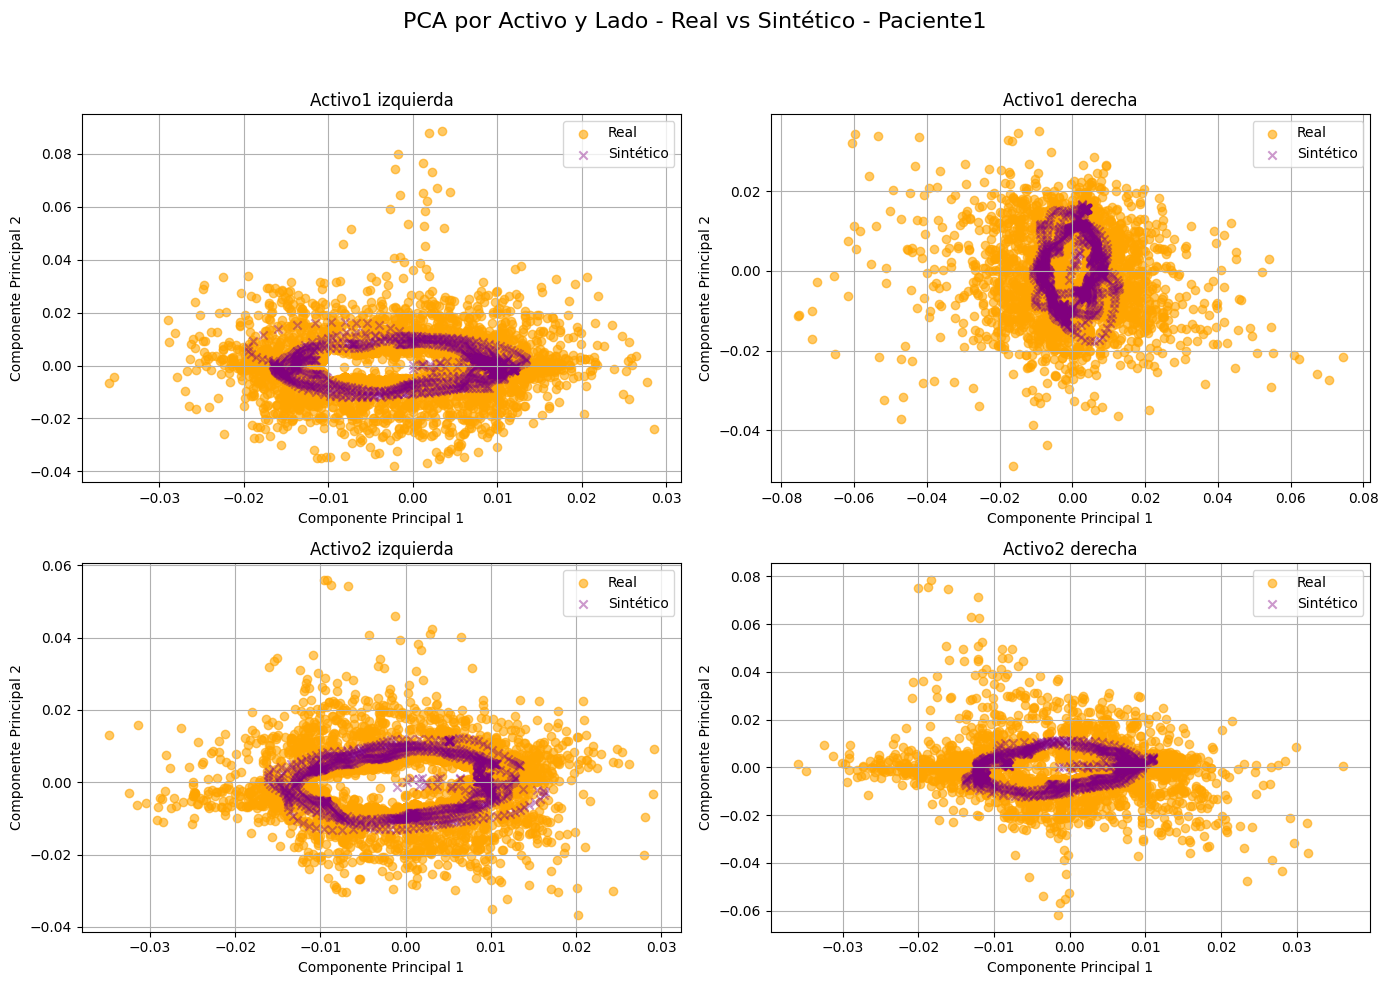

📈 Mostrando comparación H_pred para PACIENTE2


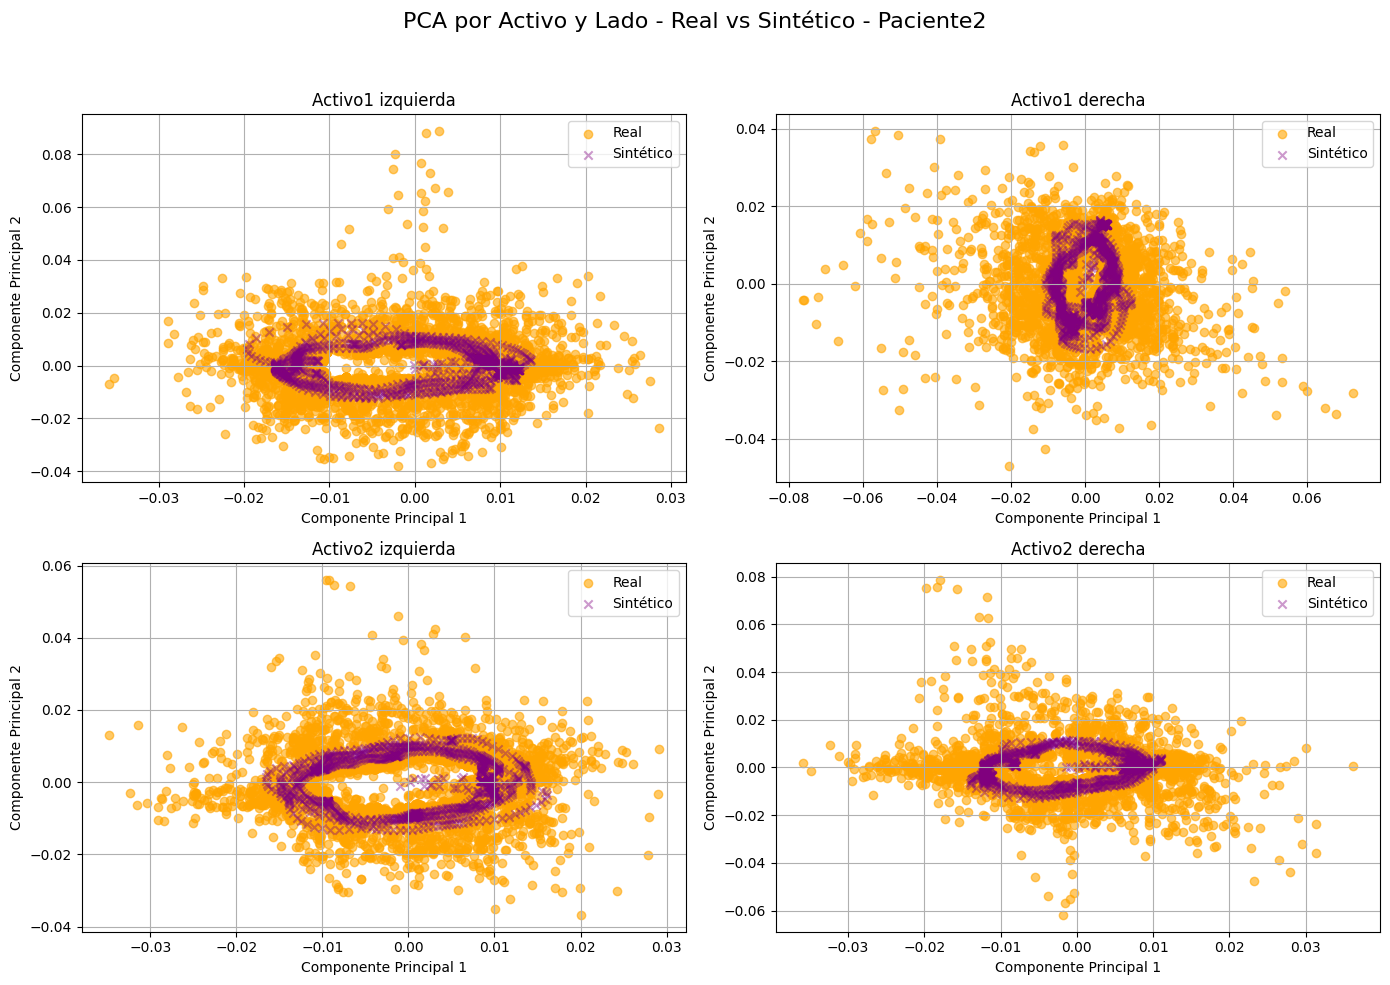

📈 Mostrando comparación H_pred para PACIENTE3


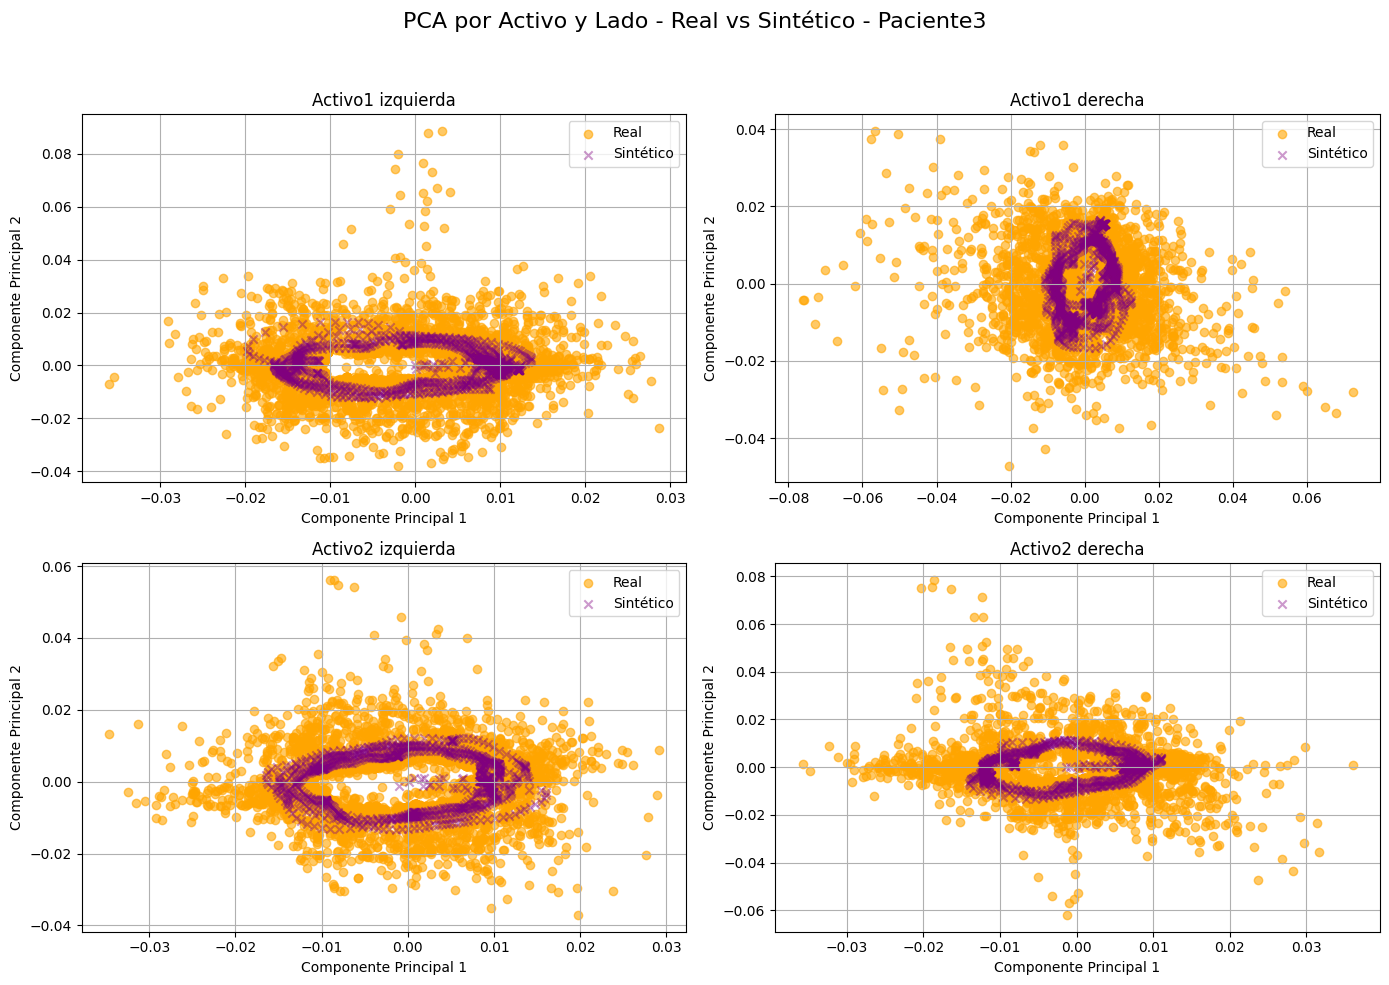

📈 Mostrando comparación H_pred para PACIENTE4


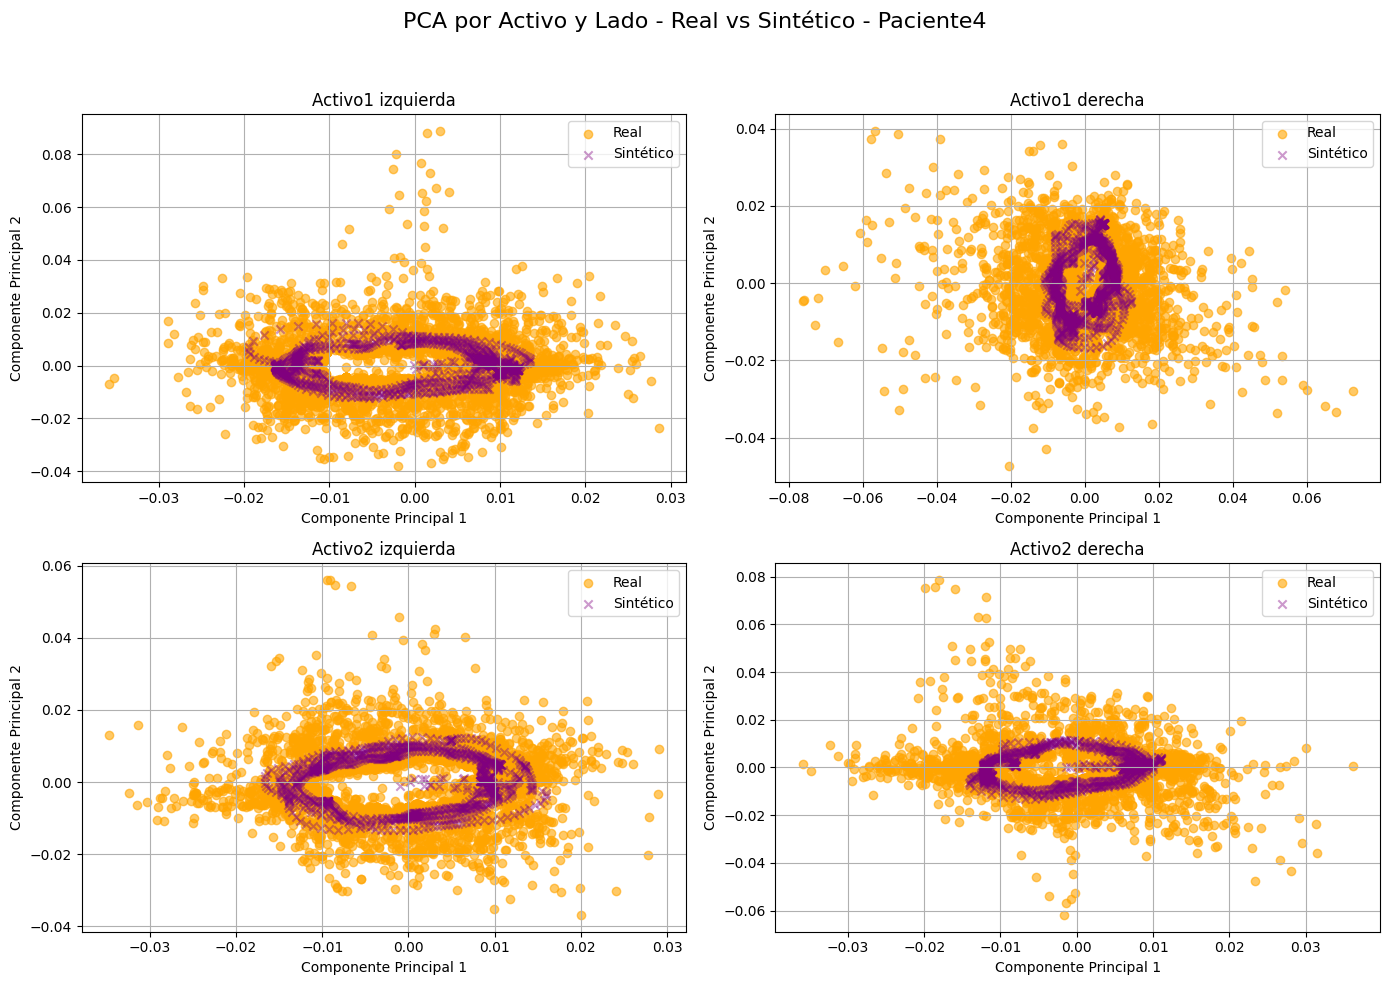

📈 Mostrando comparación H_pred para PACIENTE5


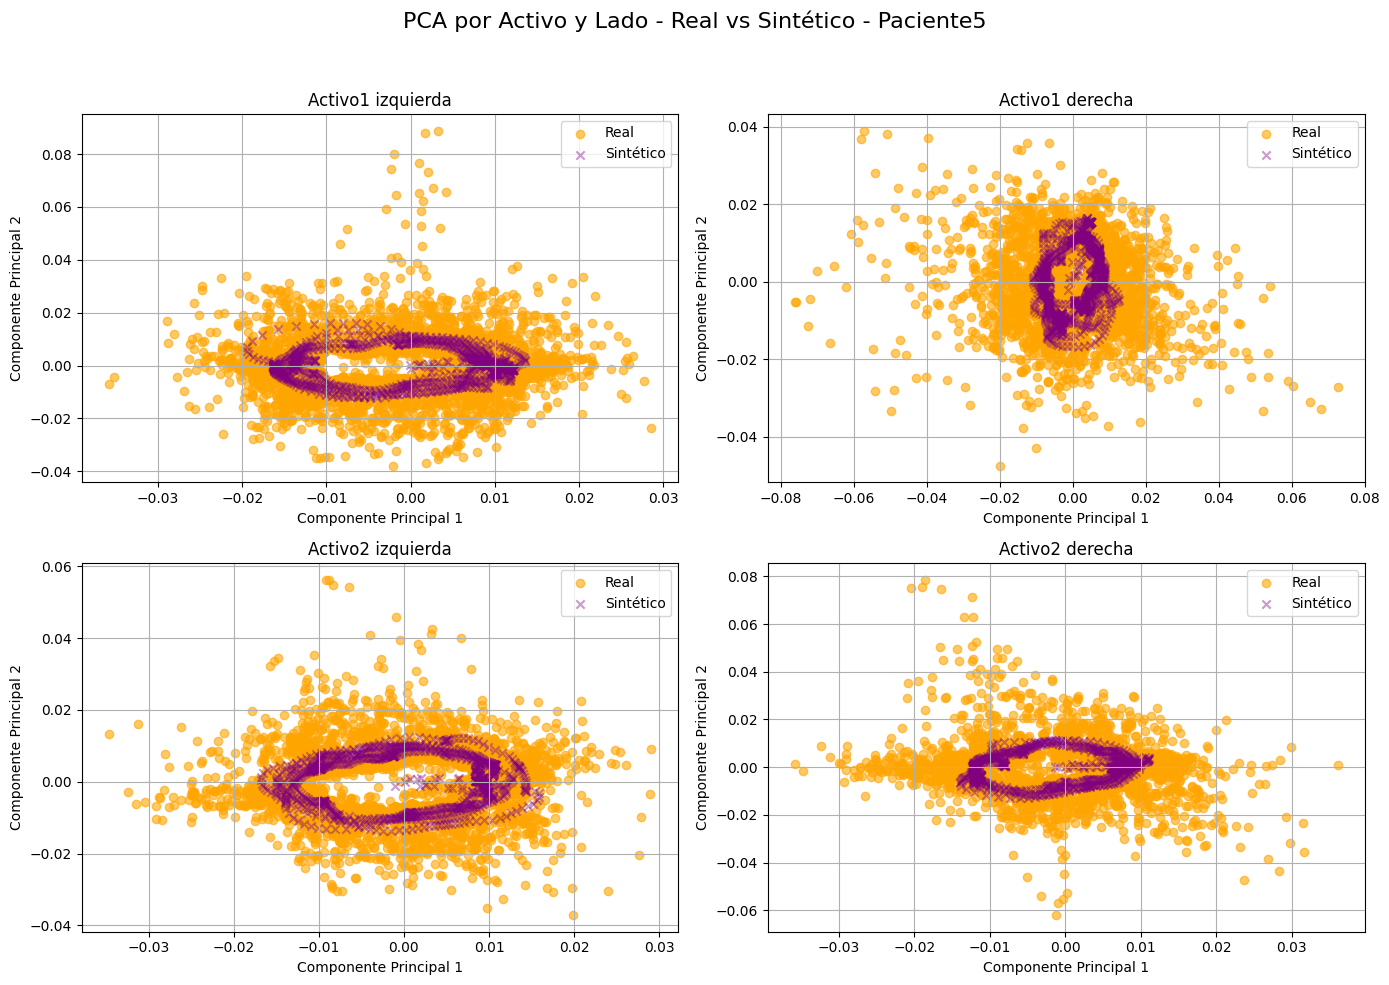

📈 Mostrando comparación H_pred para PACIENTE6


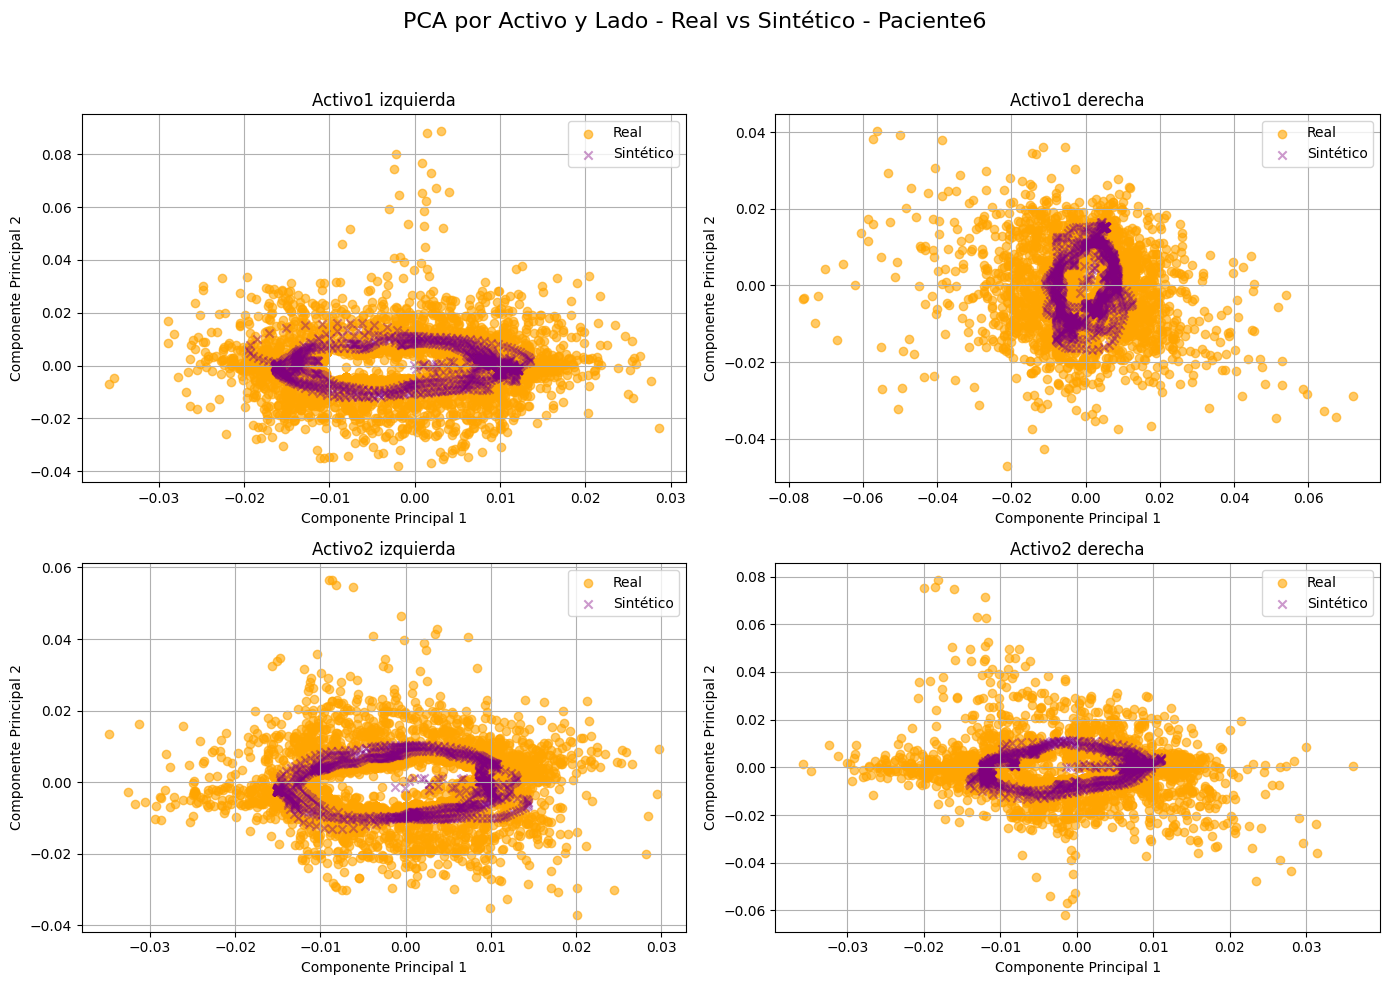

📈 Mostrando comparación H_pred para PACIENTE7


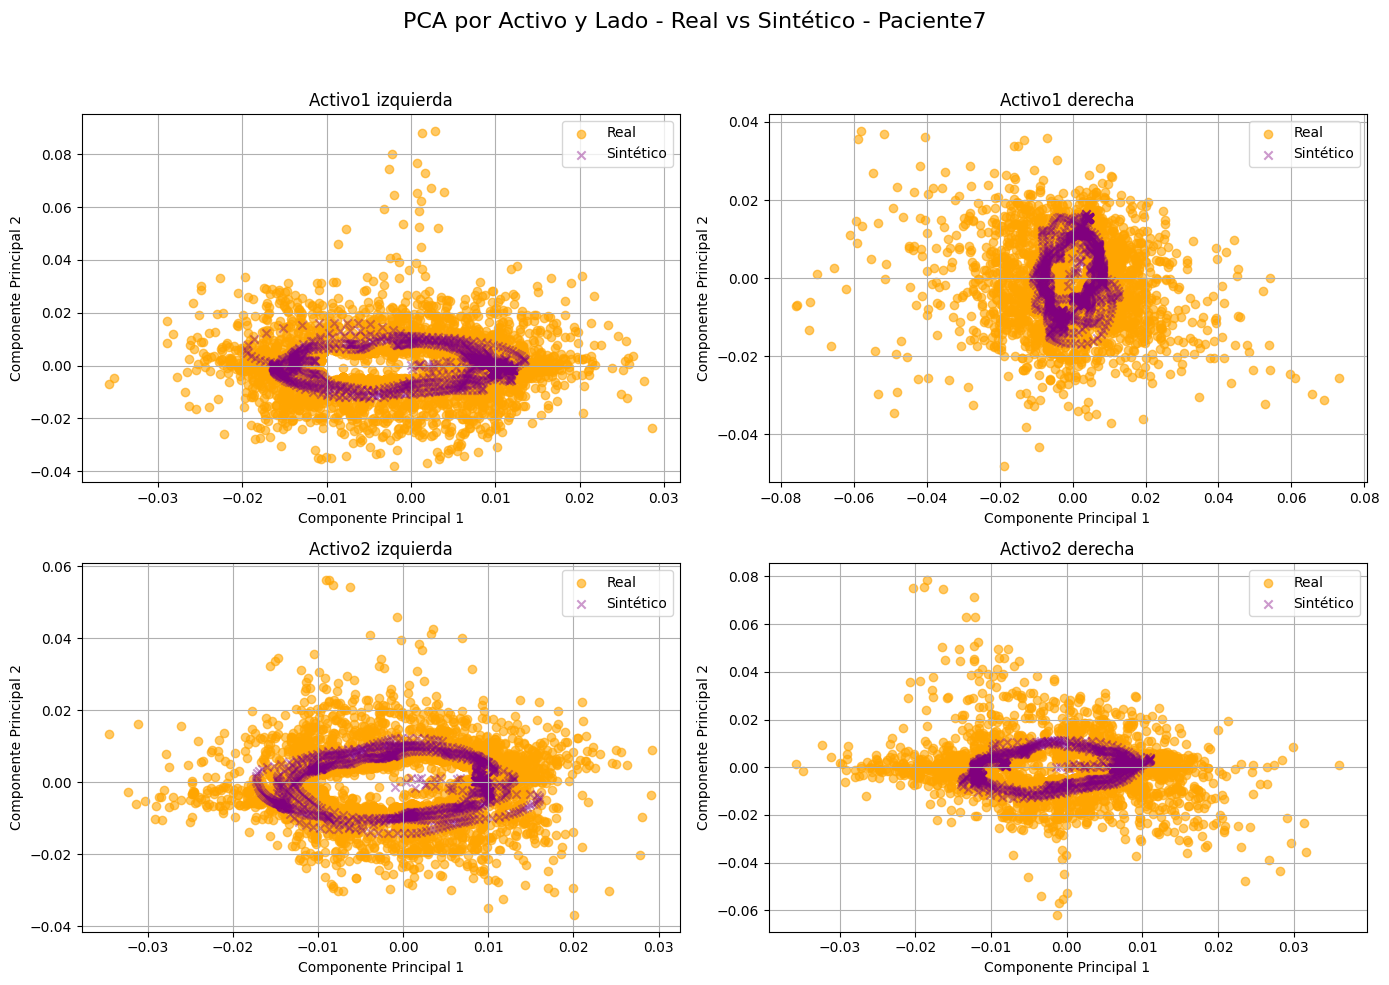

📈 Mostrando comparación H_pred para PACIENTE8


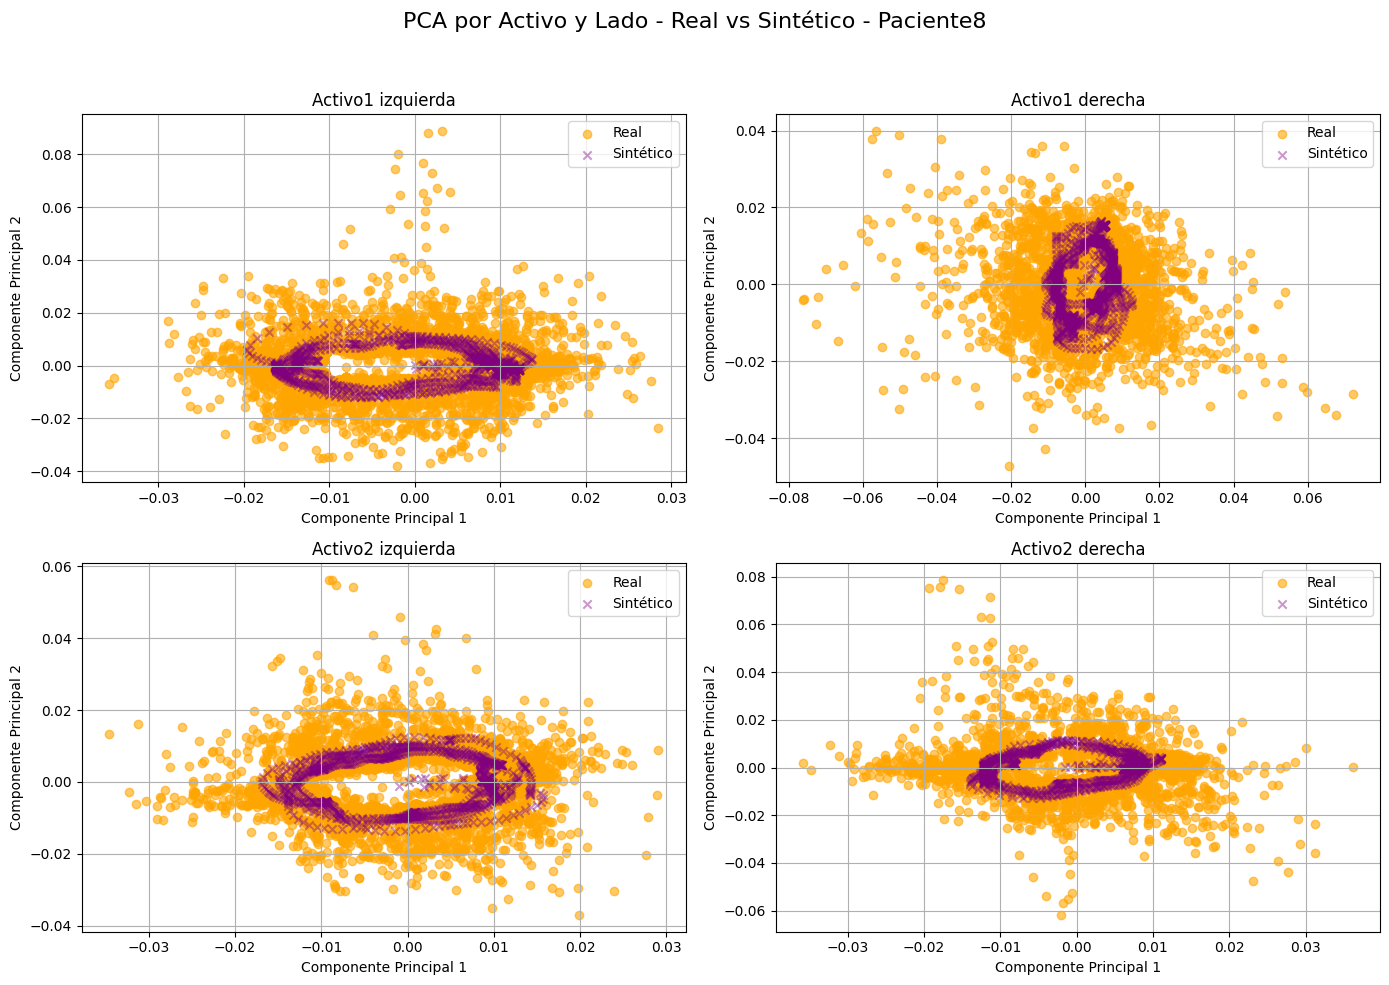

📈 Mostrando comparación H_pred para PACIENTE9


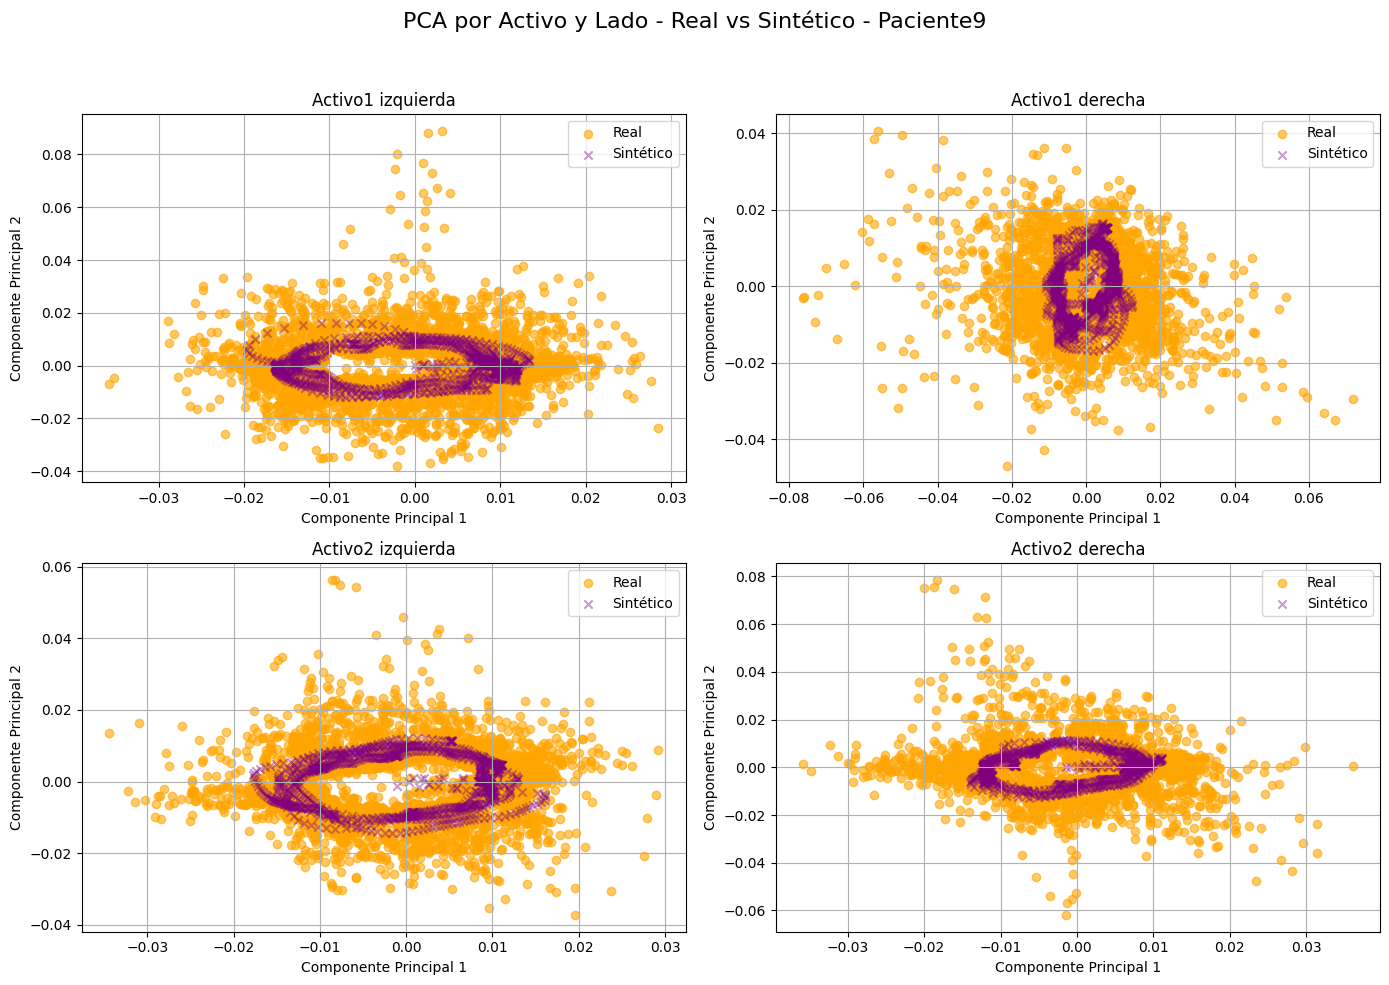

In [66]:
for i in range(1, 10):  # pacientes 1 al 9
    paciente = f"paciente{i}"
    pt = f"Paciente{i}"
    # Cargar datos sintéticos del paciente i
    synth_data = {
        "activo1_izquierda": pd.read_csv(f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/Activos1_izquierda_H_{pt.capitalize()}.csv"),
        "activo1_derecha": pd.read_csv(f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/Activos1_derecha_H_{pt.capitalize()}.csv"),
        "activo2_izquierda": pd.read_csv(f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/Activos2_izquierda_H_{pt.capitalize()}.csv"),
        "activo2_derecha": pd.read_csv(f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/Activos2_derecha_H_{pt.capitalize()}.csv"),
    }

    # Cargar datos reales (son los mismos para todos los pacientes)
    real_data = {
        "activo1_izquierda": pd.read_csv("C:/TIC_JE/Pasivos/datosPredDer/unificados/Activo1_izq_UnificadoGB.csv"),
        "activo1_derecha": pd.read_csv("C:/TIC_JE/Pasivos/datosPredDer/unificados/Activo1_der_UnificadoGB.csv"),
        "activo2_izquierda": pd.read_csv("C:/TIC_JE/Pasivos/datosPredDer/unificados/Activo2_izq_UnificadoGB.csv"),
        "activo2_derecha": pd.read_csv("C:/TIC_JE/Pasivos/datosPredDer/unificados/Activo2_der_UnificadoGB.csv"),
    }

    print(f"📈 Mostrando comparación H_pred para {paciente.upper()}")
    graficar_pca_4_subplots(real_data, synth_data, paciente=pt)
    plt.savefig(rf"C:\TIC_JE\Pasivos\predictionSyntheticTIC\images\grafica_PCA_{paciente}.png", dpi=300)
    plt.close()




- En las 4 subgráficas (por activo y lado), se observa una superposición significativa entre los puntos reales y sintéticos.

- Ambos conjuntos están centrados en la misma región del espacio PCA, lo cual indica que:

- Los datos sintéticos reproducen correctamente las correlaciones internas de las variables originales.

- La estructura estadística global entre reales y sintéticos es similar.

- Los reales tienden a tener una mayor dispersión en todas las direcciones, mientras que los sintéticos aparecen más densos y contenidos, posiblemente con menor variabilidad.

In [11]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, ks_2samp

def comparar_Hpred_por_ejercicio(real_path, sintetico_path):
    """
    Compara las predicciones Hpred0 entre datos reales y sintéticos agrupados por 'Etiqueta'.
    
    Parámetros:
    - real_path: ruta al CSV real unificado (contiene columna 'Hpred0' y 'Etiqueta')
    - sintetico_path: ruta al CSV sintético (misma estructura)

    Retorna:
    - DataFrame con métricas por ejercicio
    """
    df_real = pd.read_csv(real_path)
    df_sint = pd.read_csv(sintetico_path)

    # Asegurar consistencia en etiquetas
    df_real['Etiqueta'] = df_real['Etiqueta'].astype(str).str.strip().str.replace(" ", "")
    df_sint['Etiqueta'] = df_sint['Etiqueta'].astype(str).str.strip().str.replace(" ", "")

    ejercicios = sorted(set(df_real['Etiqueta']) & set(df_sint['Etiqueta']))
    resultados = []

    for ejercicio in ejercicios:
        h_real = df_real[df_real['Etiqueta'] == ejercicio]['Hpred0'].values
        h_sint = df_sint[df_sint['Etiqueta'] == ejercicio]['Hpred0'].values

        min_len = min(len(h_real), len(h_sint))
        if min_len < 5:
            continue  # ignorar si hay muy pocos datos

        h_real = h_real[:min_len]
        h_sint = h_sint[:min_len]

        mse = mean_squared_error(h_real, h_sint)
        mae = mean_absolute_error(h_real, h_sint)
        r2 = r2_score(h_real, h_sint)
        corr, _ = pearsonr(h_real, h_sint)
        ks_stat, ks_p = ks_2samp(h_real, h_sint)

        resultados.append({
            "Ejercicio": ejercicio,
            "MSE": mse,
            "MAE": mae,
            "R2": r2,
            "Correlación": corr,
            "KS_Stat": ks_stat,
            "KS_p_value": ks_p
        })

    return pd.DataFrame(resultados)


In [18]:
import pandas as pd

# Lista para acumular todos los resultados
tabla_global = []

for i in range(1, 10):  # pacientes 1 al 9
    paciente = f"paciente{i}"
    pt = f"Paciente{i}"

    combinaciones = {
        "activo1_izquierda": ("Activo1_izq_UnificadoGB.csv", f"Activos1_izquierda_H_{pt}.csv"),
        "activo1_derecha":   ("Activo1_der_UnificadoGB.csv", f"Activos1_derecha_H_{pt}.csv"),
        "activo2_izquierda": ("Activo2_izq_UnificadoGB.csv", f"Activos2_izquierda_H_{pt}.csv"),
        "activo2_derecha":   ("Activo2_der_UnificadoGB.csv", f"Activos2_derecha_H_{pt}.csv"),
    }

    for key, (real_file, synth_file) in combinaciones.items():
        real_path = f"C:/TIC_JE/Pasivos/datosPredDer/unificados/{real_file}"
        synth_path = f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/{synth_file}"

        try:
            df_metricas = comparar_Hpred_por_ejercicio(real_path, synth_path)
            df_metricas["Paciente"] = paciente
            df_metricas["Combinación"] = key
            tabla_global.append(df_metricas)
        except Exception as e:
            print(f"❌ Error en {paciente} - {key} - {e}")

# Concatenar todo y guardar
df_final = pd.concat(tabla_global, ignore_index=True)
df_final.to_csv("metricas_H_pred_Global.csv", index=False)
print("✅ Archivo guardado como metricas_H_pred_Global.csv")


✅ Archivo guardado como metricas_H_pred_Global.csv


In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr
from dtaidistance import dtw

def comparar_Hpred_por_ejercicio_robusto(real_path, sintetico_path):
    """
    Compara los valores de H_pred entre datos reales y sintéticos por ejercicio
    utilizando métricas robustas. Retorna un DataFrame.
    """

    try:
        df_real = pd.read_csv(real_path)
        df_sint = pd.read_csv(sintetico_path)

        # Asegurar consistencia en etiquetas
        df_real['Etiqueta'] = df_real['Etiqueta'].astype(str).str.strip().str.replace(" ", "")
        df_sint['Etiqueta'] = df_sint['Etiqueta'].astype(str).str.strip().str.replace(" ", "")

        ejercicios = sorted(set(df_real['Etiqueta']) & set(df_sint['Etiqueta']))
        resultados = []
        for ej in ejercicios:
            real_ej  = df_real[df_real['Etiqueta'] == ej]['Hpred0'].values
            sint_ej = df_sint[df_sint['Etiqueta'] == ej]['Hpred0'].values
            # Validación de longitud
            if len(real_ej) != len(sint_ej):
                min_len = min(len(real_ej), len(sint_ej))
                real_ej = real_ej[:min_len]
                sint_ej = sint_ej[:min_len]

            # Métricas
            mse = mean_squared_error(real_ej, sint_ej)
            rmse = np.sqrt(mse)
            nrmse = rmse / (np.max(real_ej) - np.min(real_ej)) if np.max(real_ej) != np.min(real_ej) else np.nan
            r2 = r2_score(real_ej, sint_ej)
            dtw_dist = dtw.distance(real_ej, sint_ej)
            auc_real = np.trapz(real_ej)
            auc_sint = np.trapz(sint_ej)
            auc_error = abs(auc_real - auc_sint)
            spearman_corr, _ = spearmanr(real_ej, sint_ej)
            pearson_corr, _ = pearsonr(real_ej, sint_ej)

            resultados.append({
                'Etiqueta': ej,
                'MSE': mse,
                'RMSE': rmse,
                'NRMSE': nrmse,
                'R2': r2,
                'DTW': dtw_dist,
                'AUC_error': auc_error,
                'Spearman': spearman_corr,
                'Pearson': pearson_corr
            })

        df_result = pd.DataFrame(resultados)
        print("✅ Métricas calculadas:", df_result.shape)
        return df_result

    except Exception as e:
        print(f"❌ Error al procesar: {e}")
        return pd.DataFrame()  # Retorna vacío si falla


In [ ]:
import pandas as pd

# Lista de combinaciones
pacientes = [f"paciente{i}" for i in range(1, 10)]
combinaciones = {
    "activo1_izquierda": ("Activo1_izq_UnificadoGB.csv", "Activos1_izquierda_H_{}.csv"),
    "activo1_derecha": ("Activo1_der_UnificadoGB.csv", "Activos1_derecha_H_{}.csv"),
    "activo2_izquierda": ("Activo2_izq_UnificadoGB.csv", "Activos2_izquierda_H_{}.csv"),
    "activo2_derecha": ("Activo2_der_UnificadoGB.csv", "Activos2_derecha_H_{}.csv"),
}

tabla = []

for paciente in pacientes:
    pt = paciente.replace("paciente", "Paciente")
    for key, (real_file, synth_pattern) in combinaciones.items():
        real_path = f"C:/TIC_JE/Pasivos/datosPredDer/unificados/{real_file}"
        synth_file = synth_pattern.format(pt)
        synth_path = f"C:/TIC_JE/Activos/syntheticData/pPatient/{paciente}/{synth_file}"
        
        try:
            df = comparar_Hpred_por_ejercicio_robusto(real_path, synth_path)
            df["Paciente"] = paciente
            df["Combinacion"] = key
            tabla.append(df)
        except Exception as e:
            print(f"❌ Error con {paciente} - {key}: {e}")

# Concatenar resultados
df_global = pd.concat(tabla, ignore_index=True)

# Calcular estadísticas globales
resumen = df_global.describe().transpose()[["mean", "std"]]
print(resumen)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)
                 mean          std
MSE          0.000002     0.000002
RMSE         0.001453     0.000569
NRMSE        3.217932     4.560427
R2        -537.977055  1633.305268
DTW          0.016477     0.005646
AUC_error    0.178467     0.129748
Spearman    -0.314757     0.423052
Pearson     -0.351789     0.356737


In [33]:
df = comparar_Hpred_por_ejercicio_robusto(
    real_path=r'C:\TIC_JE\Pasivos\datosPredDer\unificados\Activo2_izq_UnificadoGB.csv',
    sintetico_path=r'C:\TIC_JE\Activos\syntheticData\pPatient\paciente1\Activos2_izquierda_H_Paciente1.csv'
)

print(df)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)
     Etiqueta       MSE      RMSE     NRMSE         R2       DTW  AUC_error  \
0  Ejercicio1  0.000003  0.001665  2.663642 -48.666640  0.023280   0.232106   
1  Ejercicio2  0.000002  0.001464  1.715956 -29.906141  0.018313   0.182965   
2  Ejercicio3  0.000001  0.001036  1.711102 -21.479996  0.013010   0.114549   
3  Ejercicio4  0.000003  0.001650  2.761498 -77.343573  0.023319   0.239852   
4  Ejercicio5  0.000001  0.001187  1.766047 -39.916771  0.014430   0.144191   

   Spearman   Pearson  
0 -0.920052 -0.855852  
1 -0.738459 -0.771527  
2 -0.648420 -0.388844  
3 -0.758933 -0.902444  
4 -0.493682 -0.223927  


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)


In [34]:
df = comparar_Hpred_por_ejercicio_robusto(
    real_path=r'C:\TIC_JE\Pasivos\datosPredDer\unificados\Activo2_izq_UnificadoGB.csv',
    sintetico_path=r'C:\TIC_JE\Activos\syntheticData\pPatient\paciente4\Activos2_izquierda_H_Paciente4.csv'
)

print(df)


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:3

✅ Métricas calculadas: (5, 9)
     Etiqueta       MSE      RMSE     NRMSE         R2       DTW  AUC_error  \
0  Ejercicio1  0.000002  0.001577  2.522814 -43.553685  0.018230   0.218260   
1  Ejercicio2  0.000002  0.001472  1.725201 -30.240069  0.018318   0.186136   
2  Ejercicio3  0.000001  0.001034  1.706936 -21.370651  0.012989   0.116946   
3  Ejercicio4  0.000003  0.001671  2.797289 -79.387493  0.023091   0.255878   
4  Ejercicio5  0.000001  0.001189  1.769506 -40.077177  0.014528   0.150043   

   Spearman   Pearson  
0 -0.880360 -0.821441  
1 -0.727473 -0.779525  
2 -0.626929 -0.335262  
3 -0.623340 -0.754711  
4 -0.430865 -0.143371  


C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:38: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_real = np.trapz(real_ej)
C:\Users\Jeimm\AppData\Local\Temp\ipykernel_2560\3933286772.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_sint = np.trapz(sint_ej)


## 6. Conclusiones

- A partir del análisis de las proyecciones PCA, se observa que los datos sintéticos generados por el modelo TimeGAN presentan una estructura estadística muy similar a la de los datos reales. En cada combinación de activo y lado (Activo1/2, Izquierda/Derecha), los datos sintéticos se agrupan en la misma región del espacio de componentes principales que los datos reales, lo que indica que el generador ha aprendido correctamente las relaciones multivariadas entre las variables de entrada. Aunque los datos sintéticos muestran una menor dispersión, lo que podría sugerir una subestimación de la variabilidad natural, su distribución central se conserva, reflejando fidelidad estructural.

- En cuanto al comportamiento temporal, las gráficas de H_pred vs. Tiempo muestran que los datos sintéticos replican de forma consistente la evolución dinámica de la Hamiltoniana observada en los datos reales. Las curvas generadas a partir de las predicciones sobre datos sintéticos siguen el mismo patrón temporal, reproduciendo transiciones, picos y valles similares en los distintos ejercicios y combinaciones de activo/lado. Este alineamiento temporal respalda la capacidad del modelo para generalizar las dinámicas biomecánicas clave, mostrando solo leves desviaciones en suavidad o sincronización en algunos casos puntuales.

- En conjunto, estos resultados indican que el enfoque propuesto, acerca de entrenar modelos de predicción sobre datos reales y aplicarlos sobre datos sintéticos, es válido y efectivo. Los datos generados mantienen tanto la estructura global como la dinámica temporal de los datos originales, lo que permite utilizar los datos sintéticos como una alternativa confiable para análisis y simulaciones biomecánicas. Esta capacidad es especialmente útil en contextos donde el acceso a datos reales es limitado, costoso o invasivo, posicionando a este modelo como una herramienta valiosa en aplicaciones clínicas y experimentales.